# Bayesian inference for multinomial model

---
#### Topic of this week
1. Bayesian inference, evaluation
    * Marginal likelihood with new parameter
    * Bayesian Credible Interval, Highest Density Posterior Interval
    * Bayesian model selection: Bayesian Factor
2. Sampling from distribution:
    * Direct sampling. Univariate vs multivariate.
    * Monte-Carlo Markov Chain.
    * Metropolis-Hasting vs NUTS
    * Implementation
3. Estimating parameter N (sample size)
    * Binomial // for this case, Bayesian inference quickly converges to the true parameter value
    * Multinomial
4. Bayesian Inference NUTS/MH parameters
    * Effective sample size (ESS)
    * Test for lack of convergence $\hat{R}$
5. TODO next week:
    * Marginal likelihood of the model
    * Implementations from scratch
    * Continuous model
---

#### Failed experiment
0. Idea:
    * We want to see how good is the inferred parameter.
    * Fixing the true parameter P, continually sample from it (so false beliefs does not spread)
    * After fitting from multiple sample generated from P, the estimated model parameter should converge to true parameter P
1. Experiment setup
    * generate a fixed parameter vector P for the multinomial distribution
    * declare the data model and the prior 
    * incrementally fit: repeat ( generate observed data X using P; compute the posterior, use it as the next iteration prior); for each iteration save the trace
2. Expected result:
    * the HPD (highest probability density interval) becomes narrower after each iteration ( more confident)
    * HPD should contains the true parameter P
3. Actual problem:
    * the iteration scheme is more complicated: including information from last posterior to current prior is called hyperparameter estimation. It is a different problem. I do not know how to implement it for multinomial
    * the Bayesian Credible Set interval (BCI), which contains the HPD, is multimodal (several peaks) instead of unimodal (only one peak). HPD does not contain the true P
   
#### Different approach (frequentist on sample data)
0. Idea:
    * Strong point of Bayesian inference is that we do not need a lot of data,
    * Instead, we ask : how many trials is needed to represent the parameter vector P
    * Experiment done in binomial case, it is observed that BCI becomes narrower and its peak is closer to true P as sample size increase
1. Experiment:
    * Do Bayesian inference with only 1 iteration, but observe the L1 distance between Estimated value and observed value
    * Observe how L1 distance change as the number of trials change
    * As the number of trials increases, the estimated parameter should converge to real parameter P
2. Literature
    * Steven K. Thompson (1987) Sample Size for Estimating Multinomial Proportions, The American Statistician, 41:1, 42-46, DOI: 10.1080/00031305.1987.10475440

#### Another problem
1. PyMC3 does not provide a general method to calculate marginal likelihood, must implement by myself
2. logp() method of PyMC3 is the log pdf, used for calculation instead of actual pdf

#### TODO
1. Implement the whole experiment from scratch, including sampling (NUTS/MH)
2. Simultaneously: continuous model: Run dennis's SIR model, plot, generate timeseries model for CRN SIR
___

Import necessary libraries

In [71]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed, randint
import collections
from scipy import stats

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

Experiment setup:
1. Data synthesis: sample from a fixed parameter
2. Setting up model, estimate the parameter by Bayesian inference
3. Repeat from 1, observe the convergence of estimated parameter after each iteration

## Model formulation

Let $\mathbf{p}=(p_1,\ldots,p_k)$ be the probability of observing $1,\ldots,k$ bees who stung in total $n$ experiments (trials), we have:
\begin{align*}
    f(x_1,\ldots ,x_k|n,p_1,\ldots,p_k) = \frac{n!}{x_1!\ldots x_k!}p_1^{x_1}\ldots p_k^{x_k}
\end{align*}
In order to exploit conjugated distribution, we assume that prior distribution of parameter $\mathbf{p}$ is assumed to be of Dirichlet distribution. (Here must be denoted by \pi (prior))
\begin{align*}
    \pi(p_1,\ldots ,p_k) = f(p_1,\ldots ,p_k| \alpha_1,\ldots,\alpha_k) = \frac{1}{\mathbf{B}(\boldsymbol{\alpha})}p_1^{\alpha_1-1}\ldots p_k^{\alpha_k-1}
\end{align*}
The parameter $\boldsymbol{\alpha}=(\alpha_1,\ldots,\alpha_k)$ must be selected by the prior knowledge (hyper parameter). However, in this situation we assume not to have any prior knowledge, so the parameter is set to $\alpha_1=\ldots=\alpha_k=1$
We estimate the parameter $\mathbf{p}$ using Bayesian estimation:
\begin{align*}
    \hat{\mathbf{p}} = \mathbf{E}(\mathbf{p}|x_1,\ldots,x_k) = \int_{\mathbf{p}} \mathbf{p} \pi(\mathbf{p}|x_1,\ldots,x_k) d\mathbf{p} 
\end{align*}
The challenging part of estimation is that the function under the integration is hard to sample, since it is multivariate and has computationally expensive form (*Comment: check again if this argument is correct; in binomial case must we use MCMC or can we compute the integral analytically*). However, we can use Monte Carlo Markov Chain (MCMC) to sample.

## Data synthesis

Consider the following experiment: put $k$ bees into a box, in steady state observe the number of bees among $k$ bees who stung. Assume that we have $n$ independent experiment of the described setup. We synthesize the experiment result randomly using fixed $P$:

[0.02366597 0.03041465 0.0672525  0.0211924  0.00937058 0.03172058
 0.01246908 0.04749444 0.01544067 0.02783365 0.04855299 0.00963308
 0.03806462 0.00975637 0.04630017 0.00890182 0.05571343 0.00141849
 0.05182474 0.01209131 0.0495684  0.03458467 0.00402042 0.05989479
 0.04890572 0.07446108 0.03756945 0.04301504 0.05300709 0.00632231
 0.01953948]


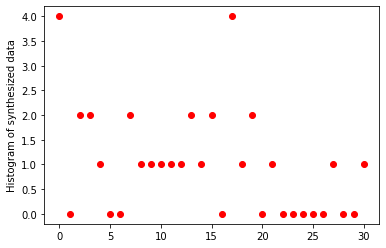

In [91]:
bee_count = 30
support_count = bee_count + 1 # can be 0 ... 30 bees sting
trials_count = 500

# Generate P
matrix = np.random.rand(1,support_count)
P = matrix/matrix.sum(axis=1)[:,None]
P = P[0] # get only x_1,.., x_k
print(P)

# Sample using P
obs = np.random.multinomial(trials_count, P, size=1)
obs = np.histogram(obs, bins=support_count)
obs = obs[0]
# Plot data
plt.plot(obs, 'ro')
plt.ylabel('Histogram of synthesized data')
plt.show()

We expect that the repeatedly applying Bayesian estimation to different samples generated using $P$, the estimated parameters $\hat{P}$ will converge to $P$

## Experiment and results

#### Experiment setup
Parameter inference is done with PyMC3[1]. As in PyMC3, NUTS (No-U-Turn sampling) is used. NUTS is a HMC (Hamiltonian Monte Carlo), which in turn is a MCMC algorithm. After sampling, we get the new estimated parameter by calculating the expectation on sample trace.

In [89]:
# Initial model
with pm.Model() as model:
    prior = pm.Dirichlet('P', a=np.ones(support_count))
    post = pm.Multinomial('X', n=obs.sum(), p=prior, observed=obs)
    trace = pm.sample(1000, tune=5000)
    
#traces = [trace]
#for _ in range(2):
#    obs = np.random.multinomial(trials_count, P, size=1)[0]
#    with pm.Model() as bees_model:
#        #prior = pm.Dirichlet('P', a=np.ones(support_count))
#        # Here must be reestimation of parameter a, but i dont know how  
#        prior = trace # [trace.P[i].mean() for i in range(0, support_count)]
#        post = pm.Multinomial('X', n=obs.sum(), p=prior, observed=obs)
#        # PyMC3 samples by NUTS (No-U-Turn sampling), a MCMC  algorithm
#        trace = pm.sample(1000, tune=5000)
#        traces.append(trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:11<00:00, 2100.18draws/s]


In [99]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P[0],0.002,0.002,0.000,0.005,0.0,0.0,5524.0,3861.0,4730.0,2556.0,1.00
P[1],0.030,0.007,0.018,0.044,0.0,0.0,8208.0,7095.0,8164.0,3164.0,1.00
P[2],0.056,0.010,0.038,0.076,0.0,0.0,8268.0,7729.0,8134.0,2870.0,1.00
P[3],0.041,0.009,0.026,0.057,0.0,0.0,8697.0,7806.0,8574.0,2740.0,1.01
P[4],0.034,0.008,0.020,0.049,0.0,0.0,9280.0,7235.0,9505.0,2551.0,1.00
P[5],0.034,0.008,0.021,0.049,0.0,0.0,8604.0,7255.0,8778.0,2745.0,1.00
P[6],0.060,0.010,0.042,0.080,0.0,0.0,10520.0,9769.0,10342.0,3456.0,1.00
P[7],0.002,0.002,0.000,0.005,0.0,0.0,5447.0,3595.0,5030.0,2536.0,1.00
P[8],0.028,0.007,0.014,0.040,0.0,0.0,6890.0,5864.0,7113.0,2921.0,1.00
P[9],0.011,0.005,0.004,0.020,0.0,0.0,7789.0,5479.0,8155.0,2984.0,1.00


Posterior distributions after 1 iterations.


/home/huypn12/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (4000) than draws (31). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/home/huypn12/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/huypn12/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/huypn12/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/huypn12/.pyenv/versions/anac

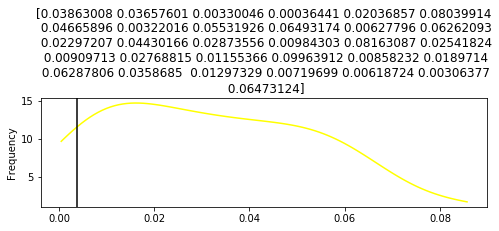

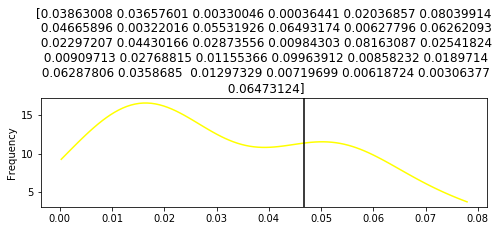

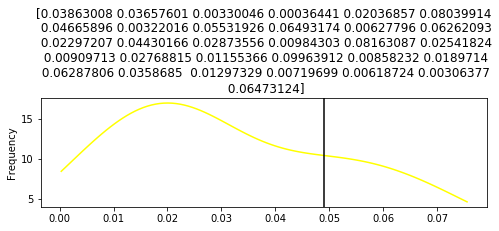

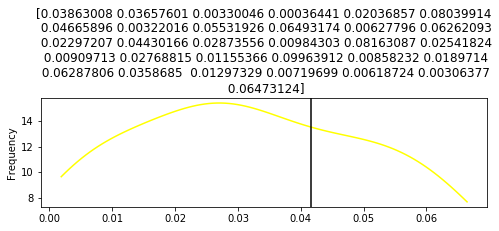

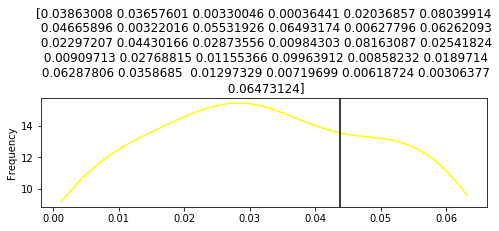

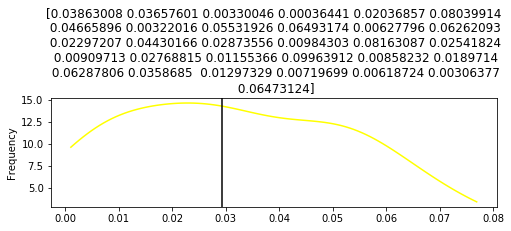

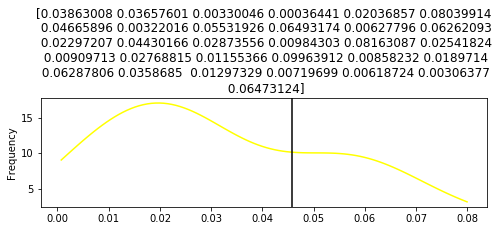

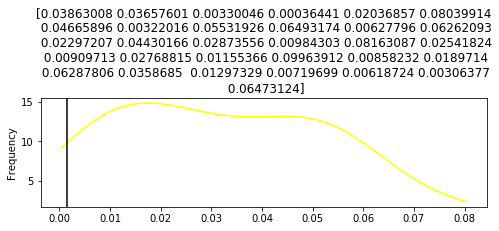

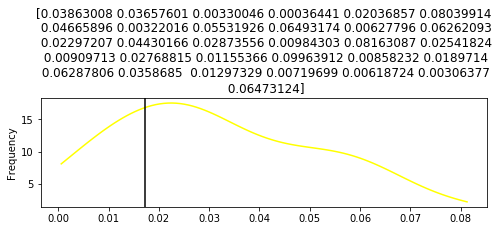

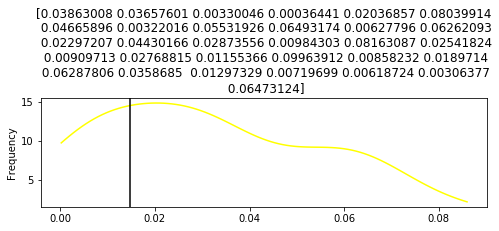

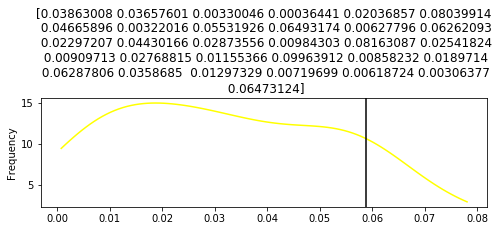

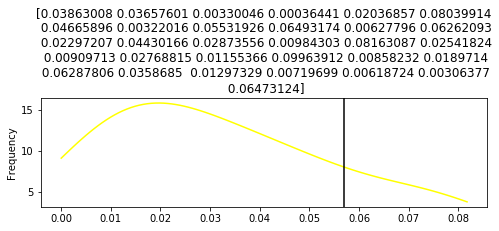

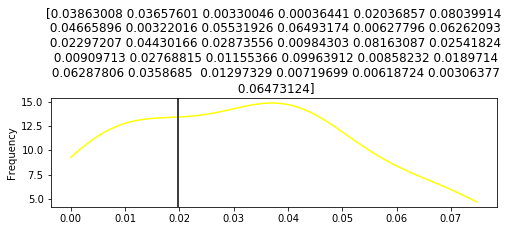

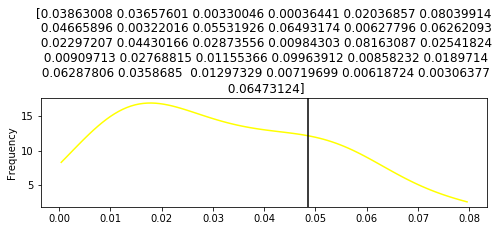

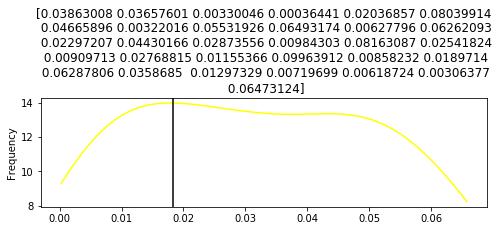

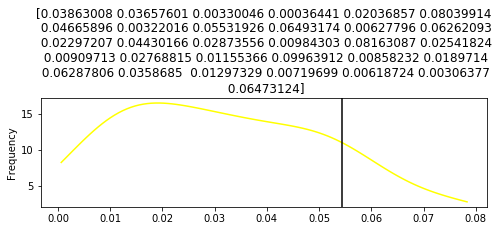

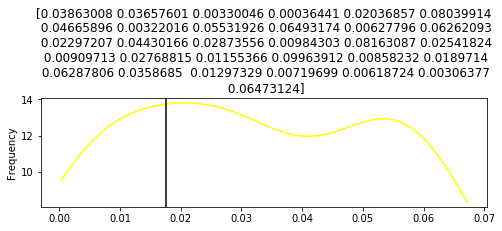

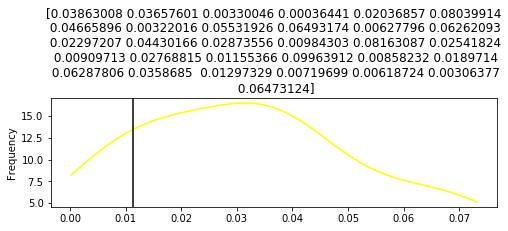

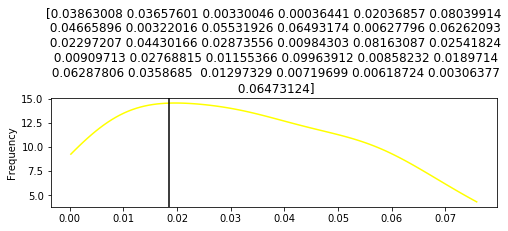

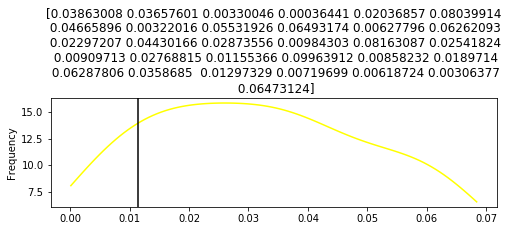

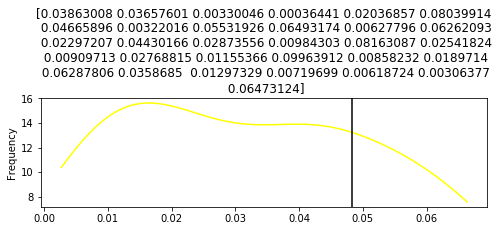

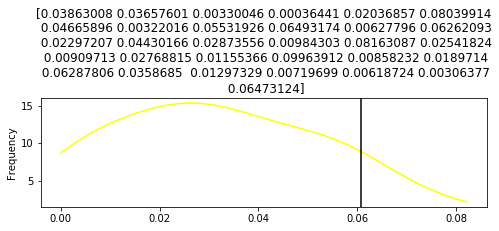

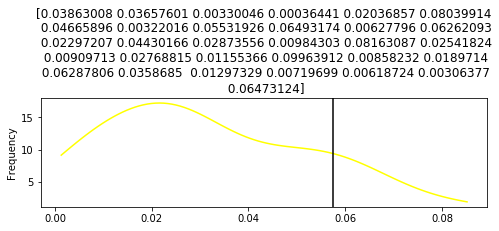

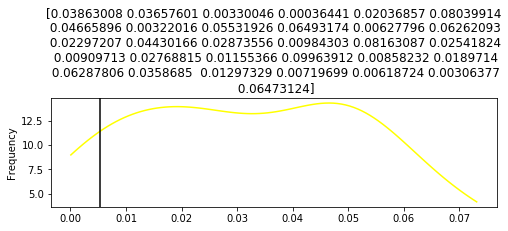

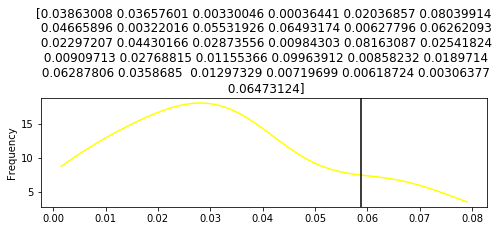

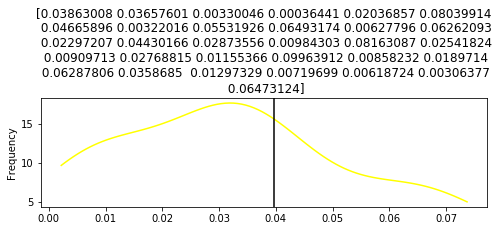

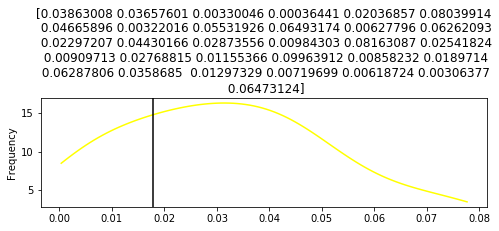

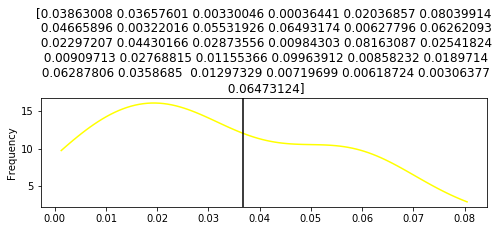

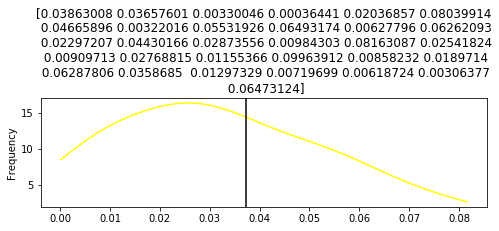

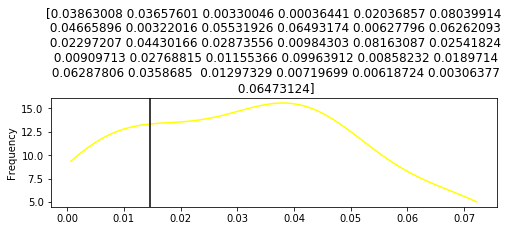

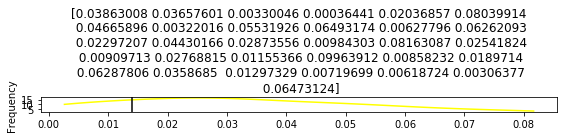

In [90]:
print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
cmap = mpl.cm.autumn
pm.summary(trace.P)
for i in range(0, support_count):
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace.P[i]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        # this function is to approximate a distribution fuction from sample data points
        y = stats.gaussian_kde(samples)(x) 
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    avxlines = {}
    plt.axvline(P[i], c='k')
    plt.ylabel('Frequency')
    plt.title(param)

plt.tight_layout();

*Explanation* : 

### Estimated parameters

In [ ]:
import arviz as az
az.plot_trace(trace)

Estimate $\hat{\mathbf{p}}$

In [107]:
from dendropy.mathlib import probability as prob
from dendropy.mathlib import statistics as dstats
import math

def estimate_mean(mcmc, field):
    results = mcmc[field]
    results = zip(*results)
    means = []
    for r in results:
        m, v = dstats.mean_and_sample_variance(r)
        means.append(m)
    means.append(1.0 - sum(means))
    return means

print(len(trace))
tags = [('estimated p_' + str(i)) for i in range(0, support_count)]
p_hat = estimate_mean(trace, 'P')
for it in zip(*[tags, p_hat]):
    print('{0} = {1}, real = {2}, diff = {3}'.format(it[0], it[1], P[i], abs(P[i] - it[1])))
print("______________________________")
print("Sum = {}".format(sum(p_hat)))

1000
estimated p_0 = 0.001901998828064672, real = 0.019539478394239442, diff = 0.01763747956617477
estimated p_1 = 0.03019812578132606, real = 0.019539478394239442, diff = 0.010658647387086616
estimated p_2 = 0.056384873966712296, real = 0.019539478394239442, diff = 0.03684539557247285
estimated p_3 = 0.04143518748936682, real = 0.019539478394239442, diff = 0.02189570909512738
estimated p_4 = 0.033939869372095005, real = 0.019539478394239442, diff = 0.014400390977855563
estimated p_5 = 0.0339868616563016, real = 0.019539478394239442, diff = 0.014447383262062154
estimated p_6 = 0.060243190312479676, real = 0.019539478394239442, diff = 0.04070371191824024
estimated p_7 = 0.001850427146491911, real = 0.019539478394239442, diff = 0.01768905124774753
estimated p_8 = 0.02822454173833309, real = 0.019539478394239442, diff = 0.00868506334409365
estimated p_9 = 0.011403065711883214, real = 0.019539478394239442, diff = 0.008136412682356228
estimated p_10 = 0.06025704228480243, real = 0.019539478

Plotting

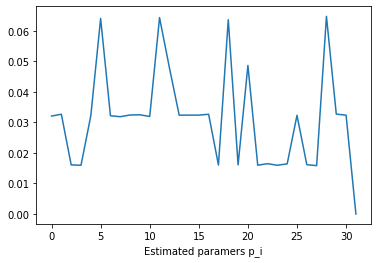

In [96]:
plt.plot(p_hat)
plt.xlabel('Estimated paramers p_i')
plt.show()

TODO: likelihood

## Evaluation

In this section, we discuss (1) *how good is a model*, and (2) *how to select the best model among many*

### Posterior predictivity

### Bayesian credible interval (BCI) and Highest Posterior Density Interval (HPDI)
#### Bayesian credible interval
Bayesian Credible Interval (BCI) is the interval 
#### Highest Posterior Density

### Bayesian model selection
#### Bayesian factor
#### AIC and BIC

## Further analysis

### Effective Sample Size (ESS)
The convergence of MCMC is discussed on Gelman-Rubin survey.

In [14]:
pm.stats.ess(trace)

<xarray.Dataset>
Dimensions:      (prior_dim_0: 31)
Coordinates:
  * prior_dim_0  (prior_dim_0) int64 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
Data variables:
    prior        (prior_dim_0) float64 1.002e+04 1.023e+04 ... 9.712e+03

### Inference of parameter Binomial parameter N

___________________

### On Bayesian inference

TODO:
0. make the same experiment for binomial case
1. calculate the distance? **(how good is the new parameter), evaluation**, e.g: diff? loglikelihood? **credible sets**?
2. parameters choice(n_trials, n_bins, MCMC setup (number of chains, number of iterations))? Bernoulli case? Sample size and its influences to the credible sets?

**Todo 1.1**: Clarify how did the sampling (NUTS) works in detail.
*On references*

**Question 1.2**: How can we apply this method to the DTMCs which are using in modeling 2 and 3 bees?
*Proposal*: same methods as in frequentist approach, however with the probabilities to BSCCs estimated with Bayesian.

**Question 1.3**: __Postpone__ Further development on Continuous time model?

### On automata modeling

**Question 2.1** How is the recursive formula constructed from the automaton?

**Question 2.2** Asynchronous product of $n=2,3$ automata results in the same model we are using?

## Reference

**PyMC3 library**
Salvatier, John, Thomas V. Wiecki, and Christopher Fonnesbeck. "Probabilistic programming in Python using PyMC3." PeerJ Computer Science 2 (2016): e55.

**NUTS MCMC**
Hoffman, Matthew D., and Andrew Gelman. "The No-U-Turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo." Journal of Machine Learning Research 15.1 (2014): 1593-1623.

**Other results on approximation of prior** A Bayesian Approach to Some Multinomial Estimation and Pretesting Problems, Tom Leonard, Journal of the American Statistical Association, Vol. 72, No. 360 (Dec., 1977), pp. 869-874 (6 pages)

**Bayesian Model Selection** 
https://www.tnu.ethz.ch/fileadmin/user_upload/teaching/Methods_Models2017/11_KES_BMSS_MM_2017_4Web.pdf

**Conjugated prior for Binomial model parameter N** Adrian E. Raftery, Inference for the Binomial N Parameter: A Hierarchical Bayes Approach // find proper citation


**MCMC methods comparison** Robert, Christian & Elvira, Victor & Tawn, Nick & Wu, Changye. (2018). Accelerating MCMC algorithms. Wiley Interdisciplinary Reviews: Computational Statistics. 10. 10.1002/wics.1435. 